# Reinforcement Learning Mouse Model of Maze Discovery


### Importing neccesary libraries for data creation and visualization


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, PReLU
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
from random import randint
import os, sys, time, datetime, json, random

2025-04-11 14:41:48.310490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Code for simulating a rat in a maze with actions, agent and reward


In [3]:
# create the colors
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
mouse_mark = 0.5  # The current rat cell will be painted by gray 0.5

# numerically assign valus to possible actions
# assume rat cannot move diagonal
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict: dict[int, str] = {
    LEFT: "left",
    UP: "up",
    RIGHT: "right",
    DOWN: "down",
}

num_actions: int = len(actions_dict)

# Exploration factor
#  one of every 10 moves the agent takes a completely random action
epsilon: float = 1 / 10


# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# mouse = (row, col) initial mouse position (defaults to (0,0))


class Qmaze(object):
    def __init__(
        self,
        maze: list,
        mouse: list = (0, 0),
        valid_penalty: float = -0.04,
        invalid_penality: float = -0.75,
        visited_penality: float = -0.25,
    ):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self._valid_penality = valid_penalty
        self._invalid_penality = invalid_penality
        self._visited_penality = visited_penality

        # target cell where the "cheese" is
        # the default behaviour is that the cheese is always in the
        # bottom right corner of the maze
        self.target = (nrows - 1, ncols - 1)

        # create free cells
        self.free_cells = [
            (r, c)
            for r in range(nrows)
            for c in range(ncols)
            if self._maze[r, c] == 1.0
        ]
        # remove the target from the "free cells"
        self.free_cells.remove(self.target)

        # throw an exception if there is no way to get to the target cell
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")

        # throw an exception if the mouse is not started on a free cell
        if not mouse in self.free_cells:
            raise Exception("Invalid mouse Location: must sit on a free cell")
        self.reset(mouse)

    def reset(self, mouse):
        self.mouse = mouse
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = mouse
        self.maze[row, col] = mouse_mark
        self.state = (row, col, "start")
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = mouse_row, mouse_col, mode = self.state

        if self.maze[mouse_row, mouse_col] > 0.0:
            self.visited.add((mouse_row, mouse_col))  # mark visited cell

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = "blocked"
        elif action in valid_actions:
            nmode = "valid"
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:  # invalid action, no change mouse position
            mode = "invalid"

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        mouse_row, mouse_col, mode = self.state
        nrows, ncols = self.maze.shape
        valid_penalty = self._valid_penality
        invalid_penalty = self._invalid_penality
        visited_penalty = self._visited_penality
        if mouse_row == nrows - 1 and mouse_col == ncols - 1:
            return 1.0
        if mode == "blocked":
            return self.min_reward - 1
        if (mouse_row, mouse_col) in self.visited:
            return visited_penalty
        if mode == "invalid":
            return invalid_penalty
        if mode == "valid":
            return valid_penalty

    def act(self, action: int):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.trial_status()
        env_state = self.observe()
        return env_state, reward, status

    def observe(self):
        canvas = self.create_environment()
        env_state = canvas.reshape((1, -1))
        return env_state

    def create_environment(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r, c] > 0.0:
                    canvas[r, c] = 1.0
        # draw the mouse
        row, col, valid = self.state
        canvas[row, col] = mouse_mark
        return canvas

    def trial_status(self):
        if self.total_reward < self.min_reward:
            return "lose"
        mouse_row, mouse_col, mode = self.state
        nrows, ncols = self.maze.shape
        if mouse_row == nrows - 1 and mouse_col == ncols - 1:
            return "win"
        return "not_over"

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, _ = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows - 1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols - 1:
            actions.remove(2)

        if row > 0 and self.maze[row - 1, col] == 0.0:
            actions.remove(1)
        if row < nrows - 1 and self.maze[row + 1, col] == 0.0:
            actions.remove(3)

        if col > 0 and self.maze[row, col - 1] == 0.0:
            actions.remove(0)
        if col < ncols - 1 and self.maze[row, col + 1] == 0.0:
            actions.remove(2)

        return actions


# show 8x8 maze | WALL = BLACK | MOUSE = DARK GRAY | PATH = LIGHT GRAY | CHEESE = VERY LIGHT GRAY
def show(qmaze: Qmaze):
    plt.grid("on")
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row, col in qmaze.visited:
        canvas[row, col] = 0.6
    mouse_row, mouse_col, _ = qmaze.state
    canvas[mouse_row, mouse_col] = 0.3  # mouse cell
    canvas[nrows - 1, ncols - 1] = 0.9  # cheese cell
    img = plt.imshow(canvas, interpolation="none", cmap="gray")
    return img

## Generate Random Maze

Applying Depth First Search (DFS) to generate random maze based on entrance and exit (aka cheese) location adapted from https://www.geeksforgeeks.org/random-acyclic-maze-generator-with-given-entry-and-exit-point/


In [4]:
# Class to define structure of a node
class Node:
    def __init__(self, value=None, next_element=None):
        self.val = value
        self.next = next_element


# Class to implement a stack
class stack:
    # Constructor
    def __init__(self):
        self.head = None
        self.length = 0

    # Put an item on the top of the stack
    def insert(self, data):
        self.head = Node(data, self.head)
        self.length += 1

    # Return the top position of the stack
    def pop(self):
        if self.length == 0:
            return None
        else:
            returned = self.head.val
            self.head = self.head.next
            self.length -= 1
            return returned

    # Return False if the stack is empty
    # and true otherwise
    def not_empty(self):
        return bool(self.length)

    # Return the top position of the stack
    def top(self):
        return self.head.val


def generate_random_maze(
    rows: int = 4,
    columns: int = 4,
    initial_point: list = (0, 0),
    final_point: list = (3, 3),
):
    ROWS, COLS = rows, columns

    # Array with only walls (where paths will
    # be created)
    maze = list(list(0 for _ in range(COLS)) for _ in range(ROWS))

    # Auxiliary matrices to avoid cycles
    seen = list(list(False for _ in range(COLS)) for _ in range(ROWS))
    previous = list(list((-1, -1) for _ in range(COLS)) for _ in range(ROWS))

    S = stack()

    # Insert initial position
    S.insert(initial_point)

    # Keep walking on the graph using dfs
    # until we have no more paths to traverse
    # (create)
    while S.not_empty():
        # Remove the position of the Stack
        # and mark it as seen
        x, y = S.pop()
        seen[x][y] = True

        # This is to avoid cycles with adj positions
        if (x + 1 < ROWS) and maze[x + 1][y] == 1 and previous[x][y] != (x + 1, y):
            continue
        if (0 < x) and maze[x - 1][y] == 1 and previous[x][y] != (x - 1, y):
            continue
        if (y + 1 < COLS) and maze[x][y + 1] == 1 and previous[x][y] != (x, y + 1):
            continue
        if (y > 0) and maze[x][y - 1] == 1 and previous[x][y] != (x, y - 1):
            continue

        # Mark as walkable position
        maze[x][y] = 1

        # Array to shuffle neighbours before
        # insertion
        to_stack = []

        # Before inserting any position,
        # check if it is in the boundaries of
        # the maze
        # and if it were seen (to avoid cycles)

        # If adj position is valid and was not seen yet
        if (x + 1 < ROWS) and seen[x + 1][y] == False:
            # Mark the adj position as seen
            seen[x + 1][y] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x + 1, y))

            # Memorize the current position as its
            # previous position on the path
            previous[x + 1][y] = (x, y)

        if (0 < x) and seen[x - 1][y] == False:
            # Mark the adj position as seen
            seen[x - 1][y] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x - 1, y))

            # Memorize the current position as its
            # previous position on the path
            previous[x - 1][y] = (x, y)

        if (y + 1 < COLS) and seen[x][y + 1] == False:
            # Mark the adj position as seen
            seen[x][y + 1] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x, y + 1))

            # Memorize the current position as its
            # previous position on the path
            previous[x][y + 1] = (x, y)

        if (y > 0) and seen[x][y - 1] == False:
            # Mark the adj position as seen
            seen[x][y - 1] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x, y - 1))

            # Memorize the current position as its
            # previous position on the path
            previous[x][y - 1] = (x, y)

        # Indicates if Pf is a neighbour position
        pf_flag = False
        while len(to_stack):
            # Remove random position
            neighbour = to_stack.pop(randint(0, len(to_stack) - 1))

            # Is the final position,
            # remember that by marking the flag
            if neighbour == final_point:
                pf_flag = True

            # Put on the top of the stack
            else:
                S.insert(neighbour)

        # This way, Pf will be on the top
        if pf_flag:
            S.insert(final_point)

    # Mark the initial position
    x0, y0 = initial_point
    xf, yf = final_point
    maze[x0][y0] = 1
    maze[xf][yf] = 1

    # Return maze formed by the traversed path
    return np.asarray(maze, dtype="float")


# Test Run to ensure that function is working correctly
test_cols = 8
test_rows = 8
test_init_point = (0, 0)
test_final_point = (7, 7)

test_maze = generate_random_maze(
    rows=test_rows,
    columns=test_cols,
    initial_point=test_init_point,
    final_point=test_final_point,
)
# check that the shape generated is correct
assert test_maze.shape == (test_cols, test_rows)

### Generating a maze array and initializing a Qmaze


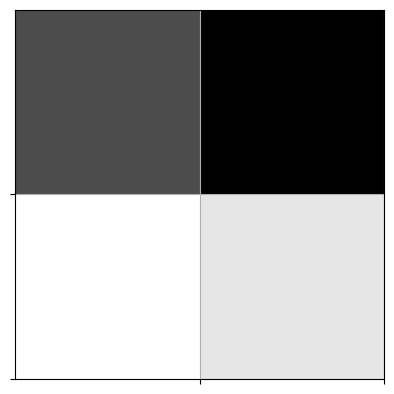

In [5]:
maze = generate_random_maze(2, 2, (0, 0), (1, 1))
qmaze = Qmaze(maze=maze)
show(qmaze)

In [6]:
class Model(object):
    def __init__(self, maze: list, learning_rate: float = 0.001):
        model = Sequential()
        model.add(Dense(maze.size, input_shape=(maze.size,)))
        model.add(PReLU())
        model.add(Dense(maze.size))
        model.add(PReLU())
        model.add(Dense(num_actions))
        model.compile(optimizer="adam", loss="mse")
        self.model = model

    def get_model(self):
        return self.model

## Create a Trial

Create an `Trial` class that accepts a trained neural network which calculates the next action, a Qmaze and the initial cell that the mouse is in.


In [7]:
class Trial:
    def __init__(self, model: Model, qmaze: Qmaze, mouse_cell: list):
        self._qmaze = qmaze
        self._model = model
        self.mouse_cell = mouse_cell

    def run(self):
        print("running trial...")
        mouse_cell = self._get_mouse_cell()
        self._qmaze.reset(mouse_cell)
        env_state = self._qmaze.observe()
        while True:
            prev_env_state = env_state
            Q = self._model.get_model().predict(prev_env_state)
            action = np.argmax(Q[0])
            _, _, status = self._qmaze.act(action)
            if status == "win":
                return True
            elif status == "lose":
                return False

    # For small mazes we can allow ourselves to perform a completion check in which we simulate all possible
    # games and check if our model wins the all. This is not practical for large mazes as it slows down training.
    def check(self):
        self._qmaze = self._get_maze()
        for cell in self._qmaze.free_cells:
            if not self._qmaze.valid_actions(cell):
                return False
            if not self.run():
                return False
        return True

    def _get_maze(self):
        return self._qmaze

    def _get_model(self):
        return self._model

    def _get_mouse_cell(self):
        return self.mouse_cell

## Creating a Class to Model the Experience of the Mouse

Create an `Experience` class that collects the experience of `Experiments` within a `list` of memory. It retreives a `model`, a `max_memory` which defines the maximum amount of experiments that the mouse can _remember_ and a `discount` factor which represents the instantanious uncertainty in the _Bellman equation for stochastic environments_.


In [8]:
class Experience(object):
    def __init__(self, model: Model, max_memory: int = 8, discount: float = 95 / 100):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.actions = model.get_model().output_shape[-1]

    def remember(self, trial):
        self.memory.append(trial)
        if len(self.memory) > self.max_memory:
            # delete the first element of the memory list if we exceed the max memory
            del self.memory[0]

    def predict(self, env_state):
        return self.model.get_model().predict(env_state)[0]

    def data(self, data_size: int = 10):
        environment_size = self.memory[0][0].shape[1]
        memory_size = len(self.memory)
        data_size = min(memory_size, data_size)
        inputs = np.zeros((data_size, environment_size))
        targets = np.zeros((data_size, self.actions))
        for idx, jdx in enumerate(
            np.random.choice(range(memory_size), data_size, replace=False)
        ):
            env_state, action, reward, env_state_next, trial_over = self.memory[jdx]
            inputs[idx] = env_state
            # There should be no target values for actions not taken.
            targets[idx] = self.predict(env_state)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(env_state_next))
            if trial_over:
                targets[idx, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[idx, action] = reward + self.discount * Q_sa
        return inputs, targets

# Q-Training Algorithm for Reinforcement Learning of Mouse
The algorithm accepts the a `number_epoch` which is the number of epochs, the maximum memory `max_memory` which is the maximum number of trials kept in memory and the `data_size` which is the number of  samples in training epoch. This is the number of trials randomly selected from the mouse's experience

In [9]:
# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [ ]:
class Experiment(object):
    def __init__(self, maze=generate_random_maze(), model_learning_rate: int = 0.001):
        qmaze = Qmaze(maze)
        model = Model(maze, learning_rate=model_learning_rate)
        trial = Trial(model, qmaze, (0, 0))
        self.qmaze = qmaze
        self.model = model
        self.trial = trial

    def train(self, **opt):
        show(self.qmaze)
        print("training....")
        global epsilon
        number_epoch = opt.get("epochs", 1000)
        max_memory = opt.get("max_memory", 8)
        data_size = opt.get("data_size", 25)
        name = opt.get("name", "model")
        start_time = datetime.datetime.now()

        # Initialize experience replay object
        experience = Experience(self.model, max_memory=max_memory)

        completion_history = []  # history of win/lose game
        number_free_cells = len(self.qmaze.free_cells)
        hsize = self.qmaze.maze.size // 2  # history window size
        win_rate = 0.0
        imctr = 1

        for epoch in range(number_epoch):
            loss = 0.0
            mouse_cell = random.choice(self.qmaze.free_cells)
            self.qmaze.reset(mouse_cell)
            trial_over = False

            # get initial env_state (1d flattened canvas)
            env_state = self.qmaze.observe()

            n_trials = 0
            while not trial_over:
                valid_actions = self.qmaze.valid_actions()
                if not valid_actions:
                    break
                prev_env_state = env_state
                # Get next action
                if np.random.rand() < epsilon:
                    action = random.choice(valid_actions)
                else:
                    action = np.argmax(experience.predict(prev_env_state))

                # Apply action, get reward and new env_state
                env_state, reward, status = self.qmaze.act(action)
                if status == "win":
                    completion_history.append(1)
                    trial_over = True
                elif status == "lose":
                    completion_history.append(0)
                    trial_over = True
                else:
                    trial_over = False

                # Store trial (experience)
                trial = [prev_env_state, action, reward, env_state, trial_over]
                experience.remember(trial)
                n_trials += 1

                # Train neural network model
                inputs, targets = experience.data(data_size=data_size)
                self.model.model.fit(
                    inputs,
                    targets,
                    epochs=1,
                    batch_size=16,
                )
                loss = self.model.model.evaluate(inputs, targets, verbose=0)

            if len(completion_history) > hsize:
                win_rate = sum(completion_history[-hsize:]) / hsize

            dt = datetime.datetime.now() - start_time
            t = format_time(dt.total_seconds())
            template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Trials: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
            print(
                template.format(
                    epoch,
                    number_epoch - 1,
                    loss,
                    n_trials,
                    sum(completion_history),
                    win_rate,
                    t,
                )
            )
            # we simply check if training has exhausted all free cells and if in all
            # cases the agent won
            if win_rate > 0.9:
                epsilon = 0.05

            if sum(completion_history[-hsize:]) == hsize:  # and self.trial.check():
                print("Reached 100%% win rate at epoch: %d" % (epoch,))
                break

        # Save trained model weights and architecture, this will be used by the visualization code
        h5file = name + ".weights.h5"
        json_file = name + ".json"
        self.model.get_model().save_weights(h5file, overwrite=True)
        with open(json_file, "w") as outfile:
            json.dump(self.model.get_model().to_json(), outfile)
        self.model.get_model().save("model.keras")
        end_time = datetime.datetime.now()
        dt = datetime.datetime.now() - start_time
        seconds = dt.total_seconds()
        t = format_time(seconds)
        print("files: %s, %s" % (h5file, json_file))
        print(
            "n_epoch: %d, max_mem: %d, data: %d, time: %s"
            % (epoch, max_memory, data_size, t)
        )
        return seconds

## Train the Model

/Users/janani/Desktop/4B/syde 552/syde_552_final_project/rl-maze-pathfinding/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


training....
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48

ValueError: The filename must end in `.weights.h5`. Received: filepath=modelweights.h5

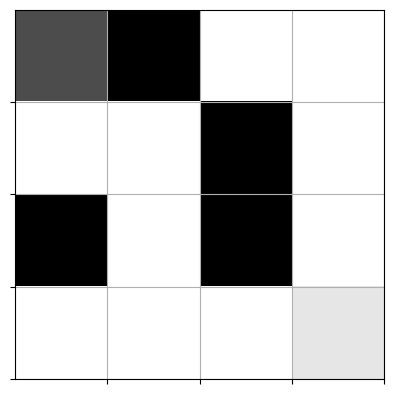

In [11]:
experiment = Experiment()

experiment.train()